In [66]:
import pandas as pd
import os

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

input_dir = "../data_clean/"
visuals_dir = "../visuals/"

In [67]:
df_person = pd.read_pickle(os.path.join(input_dir, 'df_person.pkl'))
df_bio = pd.read_pickle(os.path.join(input_dir, 'df_bio.pkl'))
df_note = pd.read_pickle(os.path.join(input_dir, 'df_note.pkl'))
df_visit = pd.read_pickle(os.path.join(input_dir, 'df_visit.pkl'))
df_condition = pd.read_pickle(os.path.join(input_dir, 'df_condition.pkl'))

In [68]:
def a_le_cancer_sein(person_id, df_condition):
    cancer_sein_codes = {"C50", "C500", "C501", "C502", "C503", "C504"}
    patient_conditions = df_condition[df_condition['person_id'] == person_id]
    return any(str(code) in cancer_sein_codes for code in patient_conditions['condition_source_value'])

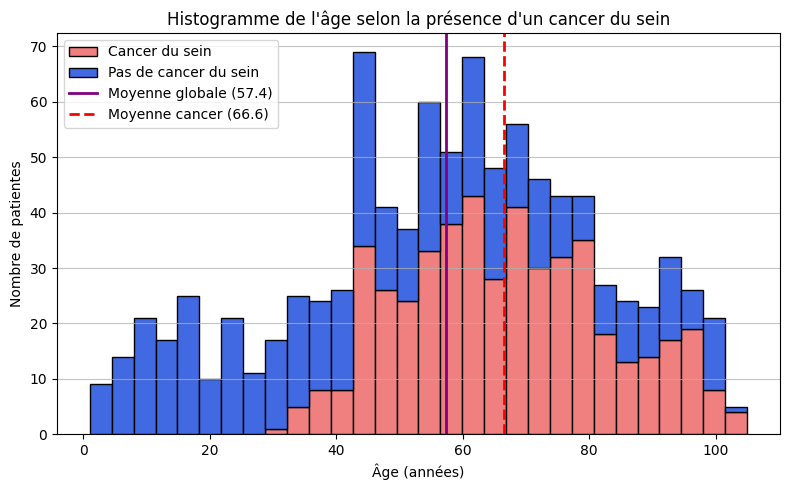

In [69]:
current_year = datetime.now().year
df_person = df_person.copy()
df_person = df_person[df_person['birth_datetime'].notna()]
df_person['age'] = current_year - df_person['birth_datetime'].dt.year

# Statut cancer du sein pour chaque personne
df_person['cancer_sein'] = df_person['person_id'].apply(lambda pid: a_le_cancer_sein(pid, df_condition))

# Séparer les âges selon le statut
age_cancer = df_person[df_person['cancer_sein'] == True]['age']
age_pas_cancer = df_person[df_person['cancer_sein'] == False]['age']

# Calcul des moyennes
moyenne_age_globale = df_person['age'].mean()
moyenne_age_cancer = age_cancer.mean()

plt.figure(figsize=(8, 5))
plt.hist(
    [age_cancer, age_pas_cancer],
    bins=30,
    stacked=True,
    color=['lightcoral', 'royalblue'],
    label=['Cancer du sein', 'Pas de cancer du sein', ''],
    edgecolor='black'
)

plt.axvline(moyenne_age_globale, color='purple', linestyle='solid', linewidth=2, label=f'Moyenne globale ({moyenne_age_globale:.1f})')
plt.axvline(moyenne_age_cancer, color='red', linestyle='dashed', linewidth=2, label=f'Moyenne cancer ({moyenne_age_cancer:.1f})')

plt.xlabel('Âge (années)')
plt.ylabel('Nombre de patientes')
plt.title("Histogramme de l'âge selon la présence d'un cancer du sein")
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()

plt.savefig(os.path.join(visuals_dir, 'histogramme_age_cancer_sein.png'), dpi=300)

plt.show()

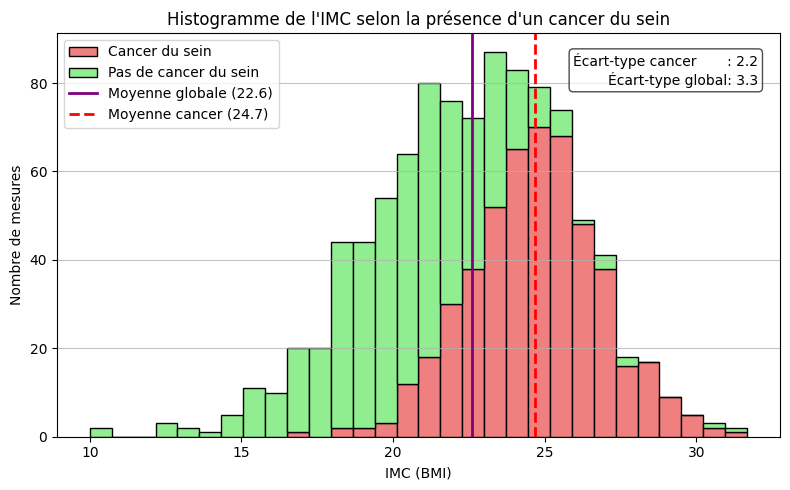

In [70]:
# 1. Lier chaque mesure d'IMC à une personne
bmi_bio = df_bio[df_bio['concept_source_value'] == 'bmi'][['visit_occurrence_id', 'transformed_value']].dropna()
bmi_bio = bmi_bio.merge(df_visit[['visit_occurrence_id', 'person_id']], on='visit_occurrence_id', how='left')
bmi_bio = bmi_bio.dropna(subset=['person_id'])

# 2. Statut cancer du sein pour chaque personne
bmi_bio['cancer_sein'] = bmi_bio['person_id'].apply(lambda pid: a_le_cancer_sein(pid, df_condition))

# Séparer les valeurs d'IMC selon le statut
bmi_cancer      = bmi_bio[bmi_bio['cancer_sein'] == True]['transformed_value']
bmi_pas_cancer  = bmi_bio[bmi_bio['cancer_sein'] == False]['transformed_value']

# Calcul des moyennes et des écarts-type
moyenne_globale     = bmi_bio['transformed_value'].mean()
moyenne_cancer      = bmi_cancer.mean()
moyenne_pas_cancer  = bmi_pas_cancer.mean()

ecarttype_cancer     = bmi_cancer.std()
ecarttype_pas_cancer = bmi_bio['transformed_value'].std()

# Visualisation de l'IMC selon la présence d'un cancer du sein
plt.figure(figsize=(8, 5))
plt.hist(
    [bmi_cancer, bmi_pas_cancer],
    bins=30,
    stacked=True,
    color=['lightcoral', 'lightgreen'],
    label=['Cancer du sein', 'Pas de cancer du sein'],
    edgecolor='black'
)

# Lignes pour les moyennes
plt.axvline(moyenne_globale, color='purple', linestyle='solid', linewidth=2, label=f'Moyenne globale ({moyenne_globale:.1f})')
plt.axvline(moyenne_cancer, color='red', linestyle='dashed', linewidth=2, label=f'Moyenne cancer ({moyenne_cancer:.1f})')
# Ajout d'un texte pour l'écart-type
# On place le texte en haut à droite du graphe. Les valeurs y sont ajustables.
plt.text(
    x=0.97, 
    y=0.95,
    s=(
        f"Écart-type cancer       : {ecarttype_cancer:.1f}\n"
        f"Écart-type global: {ecarttype_pas_cancer:.1f}"
    ),
    transform=plt.gca().transAxes,
    ha='right',
    va='top',
    fontsize=10,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
)

plt.xlabel('IMC (BMI)')
plt.ylabel('Nombre de mesures')
plt.title("Histogramme de l'IMC selon la présence d'un cancer du sein")
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()

plt.savefig(os.path.join(visuals_dir, 'bmi_histogram_cancer.png'))


/var/folders/kg/hgy_q5m96xgcws72gzltdk3r0000gn/T/ipykernel_60823/3539284599.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


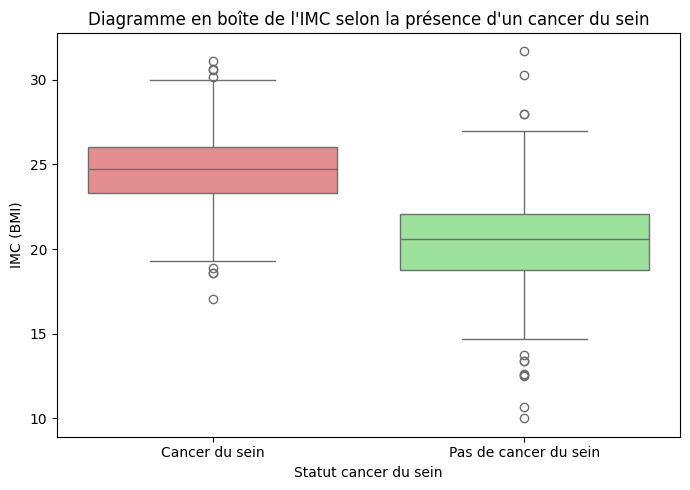

/var/folders/kg/hgy_q5m96xgcws72gzltdk3r0000gn/T/ipykernel_60823/3539284599.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


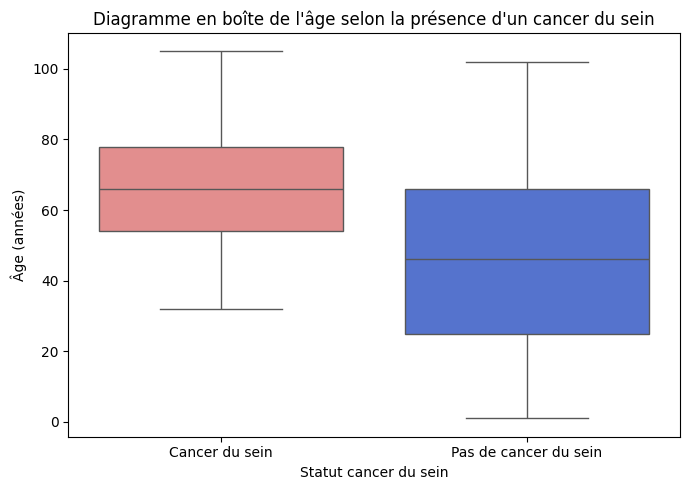

In [71]:
import seaborn as sns

# Boxplot de l'IMC selon la présence d'un cancer du sein
plt.figure(figsize=(7, 5))
sns.boxplot(
    x=bmi_bio['cancer_sein'].map({True: 'Cancer du sein', False: 'Pas de cancer du sein'}),
    y=bmi_bio['transformed_value'],
    palette={'Cancer du sein': 'lightcoral', 'Pas de cancer du sein': 'lightgreen'}
)
plt.xlabel('Statut cancer du sein')
plt.ylabel('IMC (BMI)')
plt.title("Diagramme en boîte de l'IMC selon la présence d'un cancer du sein")
plt.tight_layout()
plt.show()

# Boxplot de l'âge selon la présence d'un cancer du sein
plt.figure(figsize=(7, 5))
sns.boxplot(
    x=df_person['cancer_sein'].map({True: 'Cancer du sein', False: 'Pas de cancer du sein'}),
    y=df_person['age'],
    palette={'Cancer du sein': 'lightcoral', 'Pas de cancer du sein': 'royalblue'}
)
plt.xlabel('Statut cancer du sein')
plt.ylabel('Âge (années)')
plt.title("Diagramme en boîte de l'âge selon la présence d'un cancer du sein")
plt.tight_layout()
plt.show()